# Ensemble Learning and Random Forests
page 181<br>
See
- https://github.com/ageron/handson-ml/blob/master/07_ensemble_learning_and_random_forests.ipynb,
- https://www.kaggle.com/general/18793 (strategy A), and
- https://docs.python.org/3/library/functions.html#enumerate.

Aggregating answers from many randomly chosen people often yields a better insight on a question than asking one or a few experts. This is called the *wisdom of the crowd*. The machine learning analog to this is *Ensemble Learning* which gathers predictions from several predictors instead of just using one predictor. An algorithm that automatically employs ensemble learning is called an *ensemble Method*.<br>
*Random Forests* aggregate predictions from many different decision trees that differ by each other because of random conditions imposed on them. For example, the selection of hyperparameters and/or of training instances may be selected randomly.
## Voting Classifiers
page 181<br>
A *hard voting* classifier predicts that class that is predicted by the majority of classifiers in the predictor ensemble. Importantly, this method often performs better than the best classifier in the ensemble. A voting classifier can work very well even if all the classifiers in the ensemble are only marginally better than random guessing. This is due to the *law of large numbers*: flipping a slightly biased coin (51% heads vs. 49% tails) only three times and then hard voting for the majority face will not yield a very reliable prediction. But hard voting after flipping the coin 1000 times will yield a 75% accuracy.<br><br>
**Suggestion or tip**<br>
Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of erors, improving the ensemble's accuracy.<br><br>
Below, we use a hard voting classifier on different classifiers, all of them from Scikit-Learn to separate a moons dataset.

In [1]:
# make moons data and split it into training and testing sets (from Github link above)
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# importing four different classiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf = LogisticRegression()     # logistic regression classifier
rnd_clf = RandomForestClassifier() # random forest classifier
svm_clf = SVC()                    # support vector machine classifier          # below is the hard voting classifier
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')
voting_clf.fit(X_train, y_train)   # train the hard voting classifier

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',...
                                        

Here, the ensemble only consists of three classifiers so the *law of large numbers* does not really apply. And still the ensemble predictions made by the hard voting classifier yield the best accuracy on some occasions. While the support vector machine and the logistic regression always return the same accuracy, the random forest classifier involves randomness and thus has a varying accuracy over different runs.

In [2]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.888
VotingClassifier 0.888


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


*Hard voting* simply classifies according to the majority vote without taking into account how confident these votes are. A measure for confidence of a vote could be the probability that a classifier gives for its vote if such probability is computed by the classifier. In Scikit-Learn, one thus needs a "predict_proba()" method. Classifying according to the aggregated confidences / probabilities is called *soft voting*. To implement this in a similar fashion as the hard voting above, we simply have the support vector machine classifier calculate probabilities and change the "voting" hyperparameter of the voting classifier from "hard" to "soft".

In [3]:
svm_clf = SVC(probability=True)  # instruct SVC to calculate probabilities (taken from Github link above)
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='soft')
voting_clf.fit(X_train, y_train) # train the soft voting classifier (see last hyperparameter in the above line)
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", Futur

LogisticRegression 0.864
RandomForestClassifier 0.904
SVC 0.888


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier 0.912


## Bagging and Pasting
page 185<br>
Instead of training different models, one can also get different predictions by training the same model on different data. *Bagging* and *Pasting* are both techniques to obtain diverse (and smaller: size $m_1$) training sets from the full (and larger: size $m_2\geq m_1$) training set. This is done in a random fashion. When each training instance may occur only once in each sampled training set (size $m_1$), this is called *pasting*. When it may occur several times in the same sampled training set (size $m_1$), it is called *bagging* which is short for *bootstrap aggregating* (any instance will be strapped in, no matter what it is). The aggregation function is usually *statistical mode*, which is the same as hard voting, for classification and the average for regression.<br>
Due to the smaller training sets ($m_1$), each predictor has a higher bias (and probably also a higher variance) than if it was trained on the full training set ($m_2$). But the aggregation reduces both bias (assumption made on the data and thus on the model) and variance (model is sensitive to the addition of a new training instance). As the small training sets exist in parallel, the classifiers that are trained on only one of these small training sets each, can also be trained in parallel (they do not depend on each other). This can make training very fast if many predictors can be trained in parallel. The same applies for predictions. This possible speed-up makes bagging and pasting very popular methods.
### Bagging and Pasting in Scikit-Learn
page 186<br>
*Bagging* in implemented in Scikit-Learn with "BaggingClassifier" for classification and "BaggingRegressor" for regression. *Pasting* uses exactly these algorithms yet with the bootstrapping (bootstrap aggregating = bagging) hyperparameter set to "bootstrap=False". An ensemble using one and the same algorithm trained on several small training sets (established with Bagging or Pasting) has usually a similar bias but a smaller variance than one single such algorithm trained on the entire training set, see Figure 7-5 on page 187.<br>
Usually, *Bagging* performs a bit better than *Pasting* because allowing instances to occur several times in a small training set produces a more diverse ensemble of small training sets. But if enough compute is available one may also try both: sometimes *Pasting* produces better results.

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
# using "n_jobs=-1" in the following line uses all available cores (see last few sentences before "Bagging and ...
# ... Pasting in Scikit-Learn" above); also note "bootstrap=True" for bagging
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.928

**General note**<br>
The "BaggingClassifier" automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a "predict_proba()" method), which is the case with Decision Trees classifiers.
### Out-of-Bag Evaluation
page 187<br>
For *Bagging* with $m_1=m_2$, on average only about 63% of the instances in the full training set (size $m_2$) occur in the sampled training set (size $m_1$). This is a logical consequence of bootstrap aggregation, i.e., putting an instance in the sampled training set even if it occurs there already (once ore more times). That means that on average there are about 37% *out-of-bag* (oob) instances that do not occur in the sampled training set and can thus be used for testing. These oob instances are different for all predictors in the ensemble.<br>
Setting "oob_score=True" for a "BaggingClassifier" with "bootstrap=True" (default) in Scikit-Learn produces an automatic oob evaluation after training.

In [5]:
# use all available cores for training and compute the score performed on the out-of-bag instances for each classifier
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True)
# train
bag_clf.fit(X_train, y_train)
# show the out-of-bag score (this must be an average of "oob_score" over all "n_estimators" or something like that)
bag_clf.oob_score_

0.9013333333333333

However, ons should note that the entire ensemble has (most likely) seen all instances so our *BaggingClassifier* might still be prone to overfitting. Let's check that with the test set!

In [6]:
y_pred = bag_clf.predict(X_test)      # make predictions on the test set
print(accuracy_score(y_test, y_pred)) # check the accuracy of these predictions
print(bag_clf.oob_decision_function_) # show the predicted class probabilities

0.904
[[0.37714286 0.62285714]
 [0.37433155 0.62566845]
 [1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.09714286 0.90285714]
 [0.31016043 0.68983957]
 [0.01086957 0.98913043]
 [0.98507463 0.01492537]
 [0.99428571 0.00571429]
 [0.75287356 0.24712644]
 [0.         1.        ]
 [0.73214286 0.26785714]
 [0.87283237 0.12716763]
 [0.96470588 0.03529412]
 [0.04864865 0.95135135]
 [0.         1.        ]
 [0.96491228 0.03508772]
 [0.92571429 0.07428571]
 [0.99470899 0.00529101]
 [0.02105263 0.97894737]
 [0.32338308 0.67661692]
 [0.91758242 0.08241758]
 [1.         0.        ]
 [0.99411765 0.00588235]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.         1.        ]
 [0.61077844 0.38922156]
 [0.         1.        ]
 [1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.17837838 0.82162162]
 [1.         0.        ]
 [0.         1.        ]
 [0.38251366 0.61748634]
 [0.         1.        ]
 [1.         0.    

Even over several runs - all of which produce different results because of randomness - there is not really a sign of overfitting. The "oob_score" further above might be an average of the scores of the "n_estimators" individual scores. Due to the *law of large numbers*, it is not surprising that the ensemble performs better than the average individual classifier.<br>
The "oob_decision_function" variable allows access to the class probabilities (the calculation of a *probability* is due to the fact that the base estimator has a "predict_proba()" method). These are inferred from aggregated oob-scores.

## Random Patches and Random Subspaces
page 188<br>
Instead of only sampling a selection of instances, it is also possible to only sample a selection of features. For the Scikit-Learn's "BaggingClassifier" class this is controlled by the hyperparameters "max_features" and "bootstrap_features", which are the feature analogues of "max_samples" and "bootstrap". Sampling both instances and features is called the *Random Patches* method. Sampling features ("bootstrap_features=True" and/or "max_features"<1.0) while keeping all training instances ("bootstrap=False" and "max_samples=1.0") is called the *Random Subspaces* method. These methods can be used to get (even) more diversity in the predictor ensemble.
## Random Forests
page 189<br>
Instead of having a "BaggingClassifier" employ the "DecisionTreeClassifier" algorithm, one can directly use Scikit-Learn's "RandomForestClassifier" (or the "RandomForestRegressor" instead of the "DecisionTreeRegressor") which is optimized towards Decision Trees. The "BaggingClassifier" is still useful if one wishes to aggregate decisions from different kinds of algorithms (other than only Decistion Trees). Let's try the "RandomForestClassifier"!

In [7]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.904

By and large, the "RandomForestClassifier" has the same hyperparameters as the combination of the "BaggingClassifier" (to control the ensemble) and the "DecisionTreeClassifier" (to control the individual trees). See page 189 and footnote 11 there for details. The following "BaggingClassifier" is roughly equivalent to the above code.

In [8]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred_bag)

0.92

### Extra-Trees
page 190<br>
Due to the *law of large numbers*, ensembles and thus Random Forests rely on the independency of the aggregated predictions. Randomness leads to diversity and thus to independency. *Extremely Randomized Trees* or *Extra-Trees* use a random feature subset at each node, just like a regular tree in a Random Forest would do by default. (Note that this is different for a single Decision Tree that would search for the most relevant feature.) But *Extra-Trees* go further than the regular tree in the Random Forest by choosing a random threshold. For the ensemble, this leads once again to higher bias and lower variance. And it makes the growing of Extra-Trees much faster than a regular Random Forest. In Scikit-Learn, Extra Trees are implemented with the "ExtraTreeRegressor" and "ExtraTreeClassifier" classes.<br><br>
**Tip or suggestion**<br>
It is hard to tell in advance whether a "RandomForestClassifier" will perform better or worse than an "ExtraTreesClassifier". Generally, the only way to know is to try both and compare them using cross-validation (and tuning the hpyerparameters using grid search).
### Feature Importance
page 190<br>
For Random Forests, Scikit-Learn can measure how much a feature reduces the impurity (or entropy). Averaging this reduction of impurity (or entropy) over all trees gives the correctly weighted importance of that feature. Doing this for all features and normalizing the outcomes so they sum up to 1 shows the relative importance of a feature. Scikit-Learn does this automatically. The feature importances are accessible through the "feature_importances_" variable. Below, we output the feature importances of the iris dataset.

In [9]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09398500671749066
sepal width (cm) 0.023923069847677697
petal length (cm) 0.4566600775910901
petal width (cm) 0.42543184584374155


So Random Forests are very handy to find out what features are actually important. This can be used for feature selection.
## Boosting
page 191<br>
*Hypothesis Boosting* or just *Boosting* for short refers to sequentially ordered predictors where each tries to correct its predecessor. This allows the combination of many weak learners into one strong learner. However, parallelization of sequential predictors is not possible since the predecessor relies on the predictions of its successor. There are many boosting methods available but *AdaBoost* and *Gradient Boosting* are by far the most popular ones.
### AdaBosst
page 192<br>
*Adaptive Boosting* or *AdaBoost* for short uses a sequence of predictors where each successor increases the weight of those instances that have been misclassified by its predecessor. The amount by which the weight of these instances is increased can be manipulated with a *learning rate* hyperparameter. Once the entire sequence of predictors is trained, the ensemble makes predictions based on all predictors, where each predictor's prediction is weighted by its accuracy.<br><br>
**Warning / caution**<br>
There is one important drawback to this sequential learning technique: it cannot be parallelized (or only partially), since each predictor can only be trained after the previous predictor has been trained and evaluated. As a result, it does not scale as well as bagging or pasting.<br><br>
The weight of all instances is initalized as $w^{(i)}=1/m$, with $m$ being the number of instances. The weighted error rate of the $j$-th predictor is defined as
$$r_j=\frac{\sum_{i=1,y_j^{(i)}\neq y^{(i)}}^mw^{(i)}}{\sum_{i=1}^mw^{(i)}}\,,$$
where $y_j^{(i)}$ is the $j$-th predictor's predictions on instance $i$. This predictors weight $\alpha_j$ is then determined via
$$\alpha_j=\eta\log\frac{1-r_j}{r_j}\,,$$
where $\eta$ is the *learning rate*. Note that $\log\frac{1-r_j}{r_j}=\log(1-r_j)-\log(r_j)$ goes to $-\infty$ for $r_j\to1$ (everything wrong => go the other direction) and to $+\infty$ for $r_j\to0$ (everything right => go this direction, very far). For the next predictor, the instance weights are updated as follows:
$$w^{(i)}=\left\{\begin{array}f\text{$w^{(i)}\,\,\,\,\,\quad\qquad$ if $y^{(i)}_j=y^{(i)}$,}\\\text{$w^{(i)}\exp(\alpha_j)\quad$ if $y^{(i)}_j\neq y^{(i)}$.}\end{array}\right.$$
Then all instance weights are normalized by dividing by $\sum_{i=1}^mw^{(i)}$.<br>
This iteration stops when the specified upper bound of total predictors has been reached or when a perfect predictor has been found ($r_{\text{final}}=0$). AdaBoost predicts the class that gets the highest weighted prediction of all $N$ predictors:
$$y(x)=\text{argmax}_k\sum_{j=1,\,y_j(x)=k}^N\alpha_j$$

In [10]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)
y_pred_ada = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred_ada)

0.896

The above code produces 200 *Decision Stumps* (depth=1 => one decision node and two leaf nodes). In addition to the "AdaBoostClassifier", there is also an "AdaBoostRegressor". Scikit-Learn actually uses a multiclass version of AdaBoost called *SAMME* (Stagewise Additive Modeling using a Multiclass Exponential loss function). With just two classes, *SAMME* is equivalent to AdaBoost apart from the fact that it uses class probabilities instead of class predictions, i.e., soft voting instead of hard voting.<br><br>
**Tip or suggestion**<br>
If your AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regularizing the base estimator.
### Gradient Boosting
page 195<br>
Instead of increasing the weight of misclassified instances, *Gradient Boosting* reduces errors by training a successor algorithm on the residual errors made by the preceding algorithm. Here, we implement this with Decision Trees that are trained on a noisy quadratic dataset.

In [11]:
# generate noisy quadratic data
import numpy as np
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
# hardcode gradient boosting (in 3 stages)
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)            # 1st set of predictions
y2 = y - tree_reg1.predict(X)  # use the remaining error as features for the second predictor
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)           # 2nd set of predictions
y3 = y2 - tree_reg2.predict(X) # again, use the remaining errors as new features
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)           # 3rd set of predictions
# make prediction
X_new = np.array([[0.8]])      # new instance
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3)) # the total prediction is the sum ...
# ... of the first prediction plus the first and second correction
print(y_pred)                  # show resulting total prediction

[0.75026781]


Below, we use code from Github to display the progress of the regression as gradient boosting advances, i.e., as subsequent trees try to correct previous deviations.

In [12]:
# residual imports
import matplotlib
import matplotlib.pyplot as plt
# define plotting function
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)
# plot figures
plt.figure(figsize=(11,11))
# first prediction
plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-",
                 data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)
# first ensemble = first prediction
plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$",
                 data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)
# first correction
plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+",
                 data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)
# second ensemble = first prediction + first correction
plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)
# second correction
plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)
# second ensemble = second prediction + second correction
plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8],
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.show()

<Figure size 1100x1100 with 6 Axes>

In Scikit-Learn, one can simply use the "GradientBoostingRegressor" class instead of the above code. It has hyperparameters that tune the growth of the trees and other hyperparameters that control the gradient boosting. The following code is very similar to the one above.

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Here, the learning rate hyperparameter determines how strongly subsequent trees are taken into account. Setting it to a low value has the effect that more trees are required to fit the data well. But the predictions usually generalize better. This regularization technique is called *shrinkage*.

In [14]:
# same code as above but with 10 times more estimators and 10 times smaller learning rate
from sklearn.ensemble import GradientBoostingRegressor
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=30, learning_rate=0.1)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=30,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Let's plot the above trees (with code from Github). Note that using too many trees can lead to overfitting!

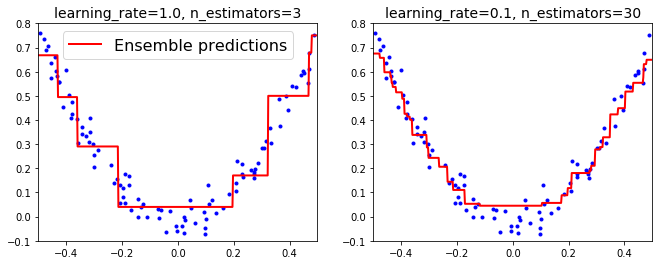

In [15]:
plt.figure(figsize=(11,4))
plt.subplot(121) # first subplot
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.subplot(122) # second subplot
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.show()

One may attempt (but not guarantee) to find the optimum number of trees as follows: (i) make so many trees (with Gradient Boosting) that you think they will be surely enough (i.e., they will most likely not underfit); (ii) on the validation set, calculate your performance measure of choice after each added tree; (iii) when overfitting sets in, this measure should go up; (iv) use that number of trees that has led to the best performance; (v) retrain an algorithm with that number of trees.<br>
Note that this is some kind of early stopping: the validation error goes up when overfitting sets in. Now, let's do this!

In [16]:
from sklearn.metrics import mean_squared_error
X_train, X_val, y_train, y_val = train_test_split(X, y)         # split dataset in training and validation sets
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120) # 120 predictors should be enough
gbrt.fit(X_train, y_train)                                      # train the model
errors = [mean_squared_error(y_val,y_pred) for y_pred in gbrt.staged_predict(X_val)] # THIS IS KEY: ...
# ... with "staged_predict" one can calculate the mean squared error after each added predictor
bst_n_estimators = np.argmin(errors)                            # in this row is the smallest validation error
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)    # retrain with this number of ...
gbrt_best.fit(X_train, y_train)                                 # ... trees

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=61,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

With code from Github, we plot the validation error as a function of the number of trees and we show the regression results obtained with the best model.

0.0031284945152031435


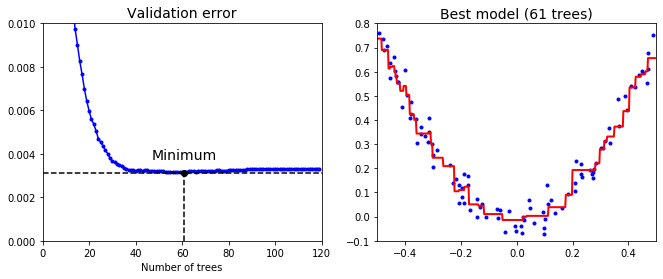

0.003154387980516349


In [17]:
min_error = np.min(errors)  # above, we only inferred in which row (=number of trees) the erros is smallest; this ...
print(min_error)            # ... here is the value of this smallest error
plt.figure(figsize=(11, 4)) # make a plot
# validation error
plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)
# best model
plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.show()
# mean squared error of best model
y_pred_best_val = gbrt_best.predict(X_val)
mse_val_best=mean_squared_error(y_val, y_pred_best_val)
print(mse_val_best)

It is also possible to implement early stopping such that the algorithm stops immediately when the validation error goes up (instead of finishing all the way and then look back at the validation error minimum). This can be achieved with "warm_start=True", which has Scikit-Learn keep existing trees. The following code stops training once the validation error did not reach a new minimum for five iterations in a row.

In [18]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True) # keep existing trees with warm_start=True
min_val_error = float("inf")                      # placeholder for minimum validation error
error_going_up = 0                                # count consecutive times of error not reaching a new minimum
for n_estimators in range(1, 120):                # loop from 1 through 120
    gbrt.n_estimators = n_estimators              # establish a new estimator (between 1 and 120)
    gbrt.fit(X_train, y_train)                    # train the new estimator
    y_pred = gbrt.predict(X_val)                  # make predictions on the validation set
    val_error = mean_squared_error(y_val, y_pred) # calculate the mean squared error on the validation set
    if val_error < min_val_error:                 # check if it is a new minimum error ...
        min_val_error = val_error                 # ... and if so: update the minimum error ...
        error_going_up = 0                        # ... and reset "error_going_up" to 0
    else:                                         # otherwise ...
        error_going_up += 1                       # increase "error_going_up" by 1 ...
        if error_going_up == 5:                   # ... and if a count of 5 has been reached ...
            print(min_val_error)                  # ... print the minimum validation error ...
            print(n_estimators)                   # ... as well as the total number of trained estimators ...
            break                                 # ... and finish the algorithm

0.0031284945152031435
67


The "GradientBoostingRegressor" also supports *Stochastic Gradient Boosting*, whereby each tree is trained only on a fraction of all available training instances. This fraction can be set with the hyperparameter "subsample", e.g. *subsample=0.25* if each predictor shall be trained on only one randomly chosen quarter of all training instances. Again, this increases the bias but lowers the variance and makes the algorithm faster.<br><br>
**General note**<br>
It is possible to use Gradient Boosting with other cost functions. This is controlled by the "loss hyperparameter" 8see Scikit-Learn's documentation for more details).
## Stacking
page 200<br>
We have learned that the aggregated predictions of the ensemble can be transformed into a final vote by hard or soft voting. Why not have a predictor make the final decision? *Stacked generalization* or *stacking* for short does exaclty that. For a given instance, the individual predictions of all the predictors act as features fed to a *blender* (final predictor) that makes the final decision.<br>
In order to train the blender, one first splits the training set into two subsets and trains the ensemble (without the blender) on the first subset. When this is done, the ensemble makes predictions on the second subset, yielding as many features (predictions) as there are predictors in the ensemble. These predictions are *clean* as the ensemble has not seen these instances during training. Then, the blender is trained on these clean predictions. Instead of using a hold-out set for training, one may also employ out-of-fold predictions, see footnote 19 on page 200 and the second link above. Using out-of-fold predictions is called *stacking* and using a hold out set is called *blending* by some people.<br>
In the second layer, one may actually train different blenders, e.g., an SVM, a Random Forest, and so on. The predictions of these blenders are then combined in a third layer. To this end, one needs to split the training data into three subsets: one to train the base predictors, the second to have the base predictors make predictions that the middle-layer blenders are trained on, and the third set for training of the top-level blender which takes predictions form the middle layer as input.<br>
Scikit-Learn does not have a stacking algorithm. However, implementing stacking will be one of the exercises of this chapter.
## Exercises
page 202
### 1.-7.
Solutions are shown in Appendix A of the book and in the separate notebook *ExercisesWithoutCode*.
### 8.
Load the MNIST data (introduced in Chapter 3), and split it into a a training set, a validation set, and a test set (e.g., use 40000 instances for training, 10000 for validation, and 10000 for testing). Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM. Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier. Once you have found one, try it on the test set. How much better does it perform compared to the indicidual classifiers?

In [19]:
# establish training, testing, and validation sets for the MNIST dataset
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
X_train_val, X_test, y_train_val, y_test = train_test_split(mnist.data, mnist.target, test_size=10000,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42)
# establish 4 different classifiers
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
random_forest_clf = RandomForestClassifier(random_state=42)
extra_trees_clf = ExtraTreesClassifier(random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)
# train the classifiers
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)
# show the scores
[estimator.score(X_val, y_val) for estimator in estimators]

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


Training the RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training the ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=42, verbose=0,
                     warm_start=False)


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training the LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training the MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)


[0.9467, 0.9512, 0.8547, 0.9608]

In [20]:
# combine the classifiers into a hard-voting ensemble classifier
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]
voting_clf = VotingClassifier(named_estimators)
voting_clf.fit(X_train, y_train)
# compare the ensemble score witht the individual scores
print(voting_clf.score(X_val, y_val))
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9625


[0.9467, 0.9512, 0.8547, 0.9608]

The ensemble is better than each of its constituents. However, the support vector machine is performing really bad. Maybe the ensemble is better without it.

In [21]:
# the following line removes the support vector machine from the ensemble, however ...
voting_clf.set_params(svm_clf=None)
voting_clf.estimators

[('random_forest_clf',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=10,
                         n_jobs=None, oob_score=False, random_state=42, verbose=0,
                         warm_start=False)),
 ('extra_trees_clf',
  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                       oob_score=False, random_state=42, verbose=0,
    

In [22]:
# ... that command does not remove it from the trained ensemble
voting_clf.estimators_

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=10,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False),
 LinearSVC(C=1.0, cla

In order to really remove the SVM from the (trained) ensemble, we can delete it explicitly as follows.

In [23]:
del voting_clf.estimators_[2]  # delete the third estimator (SVM) from the trained ensemble
voting_clf.score(X_val, y_val) # run the voting classifier again

0.9659

Indeed, the hard voting classifier performs a bit better withou the SVM!

In [24]:
# now try soft voting
voting_clf.voting = "soft"
voting_clf.score(X_val, y_val)

0.9698

The soft voting classifier performs even a bit better than the hard voting classifier. Let's try is on the test set!

In [25]:
print(voting_clf.score(X_test, y_test))                                  # ensemble score with soft voting on test set
[estimator.score(X_test,y_test) for estimator in voting_clf.estimators_] # individual scores on test set

0.97


[0.9434, 0.9444, 0.9629]

### 9.
Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifiers you trained earlier?

In [26]:
# collect all the predictions on the validation set of all 4 (still trained, see above) estimators
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32) # data container
for index, estimator in enumerate(estimators):                                # loop through columns / estimators ...
    X_val_predictions[:, index] = estimator.predict(X_val)                    # ... see third link at top of page
X_val_predictions                                                             # show the input for the blender

array([[2., 2., 2., 2.],
       [7., 7., 7., 7.],
       [4., 4., 4., 4.],
       ...,
       [4., 4., 4., 4.],
       [9., 9., 9., 9.],
       [4., 4., 4., 4.]], dtype=float32)

In [27]:
# train a random forest classifier on blending these predictions and check its score
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
print(rnd_forest_blender.fit(X_val_predictions, y_val))
print(rnd_forest_blender.oob_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)
0.9638


In [28]:
# establish test set instances (predicions of classifiers) and check the trained blender's predicions on them
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)
for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)
y_pred = rnd_forest_blender.predict(X_test_predictions)
# accuracy of blending ensemble on the test set
accuracy_score(y_test, y_pred)

0.9605